# ASSET ANALYSIS

ASSET test on fMRI data provided by J. Schreiber.

There are 300 time points (similar to binned spike trains) for 33865 source locations


In [1]:
# import packages

import numpy as np
import sys
import neo
import quantities as pq
sys.path.append('./ASSET/')
import asset
import matplotlib.pyplot as plt

In [2]:
path = '../../ASSET_fMRI/'

# data preprocessing in preprocessing_data.py file
sts = np.load(path + 'activations_st.npy')

# take only the first N channels
number_of_channels = 33865
sts = sts[0:number_of_channels]
path = path + str(number_of_channels) + '/'

## Step 1:

Build the intersection matrix (imat) and the associated probability matrix (pmat) with the desired binsize. Here we use 1s.


In [3]:
binsize = 1 * pq.s

In [20]:
# build the intersection matrix and save it
imat, xedges, yedges = asset.intersection_matrix(sts, binsize, dt, norm=2)
np.save(path + 'imat%i.npy' % number_of_channels, imat)
np.save(path + 'xedges%i.npy' % number_of_channels, xedges)
np.save(path + 'yedges%i.npy' % number_of_channels, yedges)

/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:539: RuntimeWarning: invalid value encountered in true_divide
  imat[ii, :] = imat[ii, :] / norm_coef


In [4]:
# load the already computed intersection matrix
imat = np.load(path + 'imat%i.npy' % number_of_channels)
xedges = np.load(path + 'xedges%i.npy' % number_of_channels)
yedges = np.load(path + 'yedges%i.npy' % number_of_channels)

In [22]:
# calculate the probability matrix and save it
pmat, xedges, yedges = asset.probability_matrix_analytical(spiketrains=sts,
                                                           binsize=binsize,
                                                           dt=dt,
                                                           kernel_width=10*pq.s)
np.save(path + 'pmat%i.npy' % number_of_channels, pmat)

In [5]:
# load the already computed probability matrix
pmat = np.load(path + 'pmat%i.npy' % number_of_channels)

## Step 2:

Compute the joint probability matrix jmat, using a suitable filter

In [24]:
filter_shape = (5,2)  # filter shape
nr_neigh = 5  # nr of largest neighbors
# calculate the joint probability matrix
jmat = asset.joint_probability_matrix(pmat, filter_shape, nr_neigh)
np.save(path + 'jmat%i.npy' % number_of_channels, jmat)

/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:1189: RuntimeWarning: divide by zero encountered in log
  dU_log = np.log(dU)


In [6]:
# load the joint probability matrix
jmat = np.load(path + 'jmat%i.npy' % number_of_channels)

## Step 3:

Create from pmat and jmat a masked version of the intersection matrix

In [26]:
alpha1 = 0.99
alpha2 = 0.99999
mask = asset.mask_matrices([pmat, jmat], [alpha1, alpha2])
np.save(path + 'mask%i.npy' % number_of_channels, mask)

In [7]:
# load the masked matrix
mask = np.load(path + 'mask%i.npy' % number_of_channels)

## Step 4:

Cluster significant elements of imat into diagonal structures ("DSs")

In [28]:
epsilon = 10
minsize = 2
stretch = 2

cmat = asset.cluster_matrix_entries(mask, epsilon, minsize, stretch)
np.save(path + 'cmat%i.npy' % number_of_channels, cmat)

/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:725: RuntimeWarning: divide by zero encountered in true_divide
  AngCoeff = dY / dX
/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:725: RuntimeWarning: invalid value encountered in true_divide
  AngCoeff = dY / dX
/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:728: RuntimeWarning: invalid value encountered in arctan
  Theta = np.arctan(AngCoeff)


In [8]:
cmat = np.load(path + 'cmat%i.npy' % number_of_channels)

## Step 5:

Extract sequences of synchronous events associated to each worm

In [30]:
sse = asset.extract_sse(sts, xedges, yedges, cmat)
np.save(path + 'sse%i.npy' % number_of_channels, sse)

In [9]:
# peak of the results
'''
sse : dict
    a dictionary D of SSEs, where each SSE is a sub-dictionary Dk,
    k=1,...,K, where K is the total number of clusters in cmat:

    .. centered:: D = {1: D1, 2: D2, ..., K: DK}

    Each sub-dictionary Dk represents the k-th diagonal structure
    (i.e. the k-th cluster) in cmat, and is of the form

    .. centered:: Dk = {(i1, j1): S1, (i2, j2): S2, ..., (iL, jL): SL}.

    The keys (i, j) represent the positions (time bin ids) of all
    elements in cmat that compose the SSE, i.e. that take value l (and
    therefore belong to the same cluster), and the values Sk are sets of
    neuron ids representing a repeated synchronous event (i.e. spiking
    at time bins i and j).

'''
sse = np.load(path + 'sse%i.npy' % number_of_channels).item()

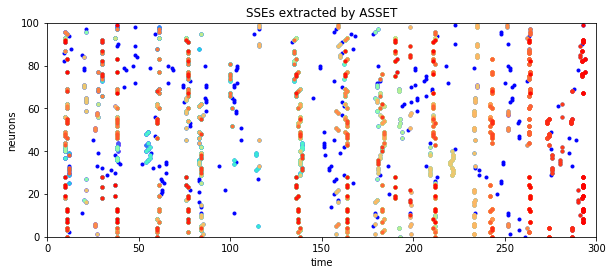

In [33]:
# plotting of the SSEs found in the data
inch2cm = 0.3937
fig1 = plt.figure(figsize=(25*inch2cm, 10*inch2cm))
ax1 = fig1.add_subplot(111)
number_sses = len(sse.keys())
colors = matplotlib.cm.rainbow(np.linspace(0,1,number_sses))
for i, st in enumerate(sts):
    for n in st:
        ax1.set_xlim(0, 300)
        ax1.set_ylim(-0.1, 100.1)
        ax1.set_xlabel('time')
        ax1.set_ylabel('neurons')
        ax1.plot(n, i, '.', color='k')
for index_sse in range(1, number_sses):
    # number_repetitions = len(sse[index_sse])
    for key, value in sse[index_sse].items():
        for bin_item in key:
            for neuron in value:
                ax1.set_xlim(0, 300)
                ax1.set_ylim(-0.1, 100.1)
                ax1.set_xlabel('time')
                ax1.set_ylabel('neurons')
                ax1.set_title('SSEs extracted by ASSET')
                ax1.plot(bin_item, neuron, '.', color=colors[index_sse])
plt.show()
fig1.savefig(path + 'scatterplot_sse%i.png' % number_of_channels)

Sneak peak of only the first 10 neurons

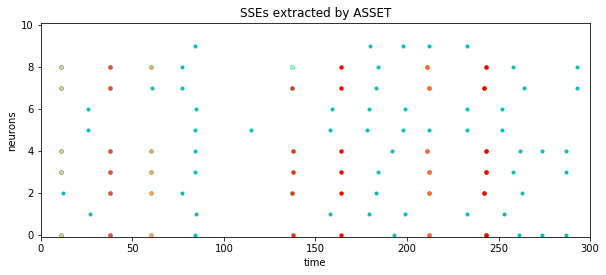

In [11]:
sse = np.load(path + '../../ASSET_fMRI/10/sse10.npy').item()
import matplotlib
# plotting of the SSEs found in the data
inch2cm = 0.3937
fig1 = plt.figure(figsize=(25*inch2cm, 10*inch2cm))
ax1 = fig1.add_subplot(111)
number_sses = len(sse.keys())
colors = matplotlib.cm.rainbow(np.linspace(0,1,number_sses))
sts = sts[0:10]
for i, st in enumerate(sts):
    for n in st:
        ax1.set_xlim(0, 300)
        ax1.set_ylim(-0.1, 10.1)
        ax1.set_xlabel('time')
        ax1.set_ylabel('neurons')
        ax1.plot(n, i, '.', color='k')
for index_sse in range(1, number_sses):
    # number_repetitions = len(sse[index_sse])
    for key, value in sse[index_sse].items():
        for bin_item in key:
            for neuron in value:
                ax1.set_xlim(0, 300)
                ax1.set_ylim(-0.1, 10.1)
                ax1.set_xlabel('time')
                ax1.set_ylabel('neurons')
                ax1.set_title('SSEs extracted by ASSET')
                ax1.plot(bin_item, neuron, '.', color=colors[index_sse])
plt.show()

# Comparison between the results of ASSET and SPADE

Sneak peak for the first 100 units, analysis with **ASSET**

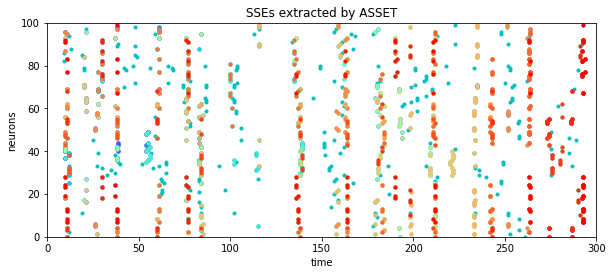

In [10]:
sse = np.load('../../ASSET_fMRI/100/sse100.npy').item()
import matplotlib
# plotting of the SSEs found in the data
inch2cm = 0.3937
fig1 = plt.figure(figsize=(25*inch2cm, 10*inch2cm))
ax1 = fig1.add_subplot(111)
number_sses = len(sse.keys())
colors = matplotlib.cm.rainbow(np.linspace(0,1,number_sses))
sts = sts[0:100]
for i, st in enumerate(sts):
    for n in st:
        ax1.set_xlim(0, 300)
        ax1.set_ylim(-0.1, 100.1)
        ax1.set_xlabel('time')
        ax1.set_ylabel('neurons')
        ax1.plot(n, i, '.', color='c')
for index_sse in range(1, number_sses):
    # number_repetitions = len(sse[index_sse])
    for key, value in sse[index_sse].items():
        for bin_item in key:
            for neuron in value:
                ax1.set_xlim(0, 300)
                ax1.set_ylim(-0.1, 100.1)
                ax1.set_xlabel('time')
                ax1.set_ylabel('neurons')
                ax1.set_title('SSEs extracted by ASSET')
                ax1.plot(bin_item, neuron, '.', color=colors[index_sse])
plt.show()

Sneak peak for the first 100 units, analysis with **SPADE**

In [ ]:
stps = np.load('../../spade_fmri/100/spade_res100.npy').item()

In [ ]:
import matplotlib
# plotting of the SSEs found in the data
inch2cm = 0.3937
fig1 = plt.figure(figsize=(25*inch2cm, 10*inch2cm))
ax1 = fig1.add_subplot(111)
number_stps = len(stps.keys())
colors = matplotlib.cm.rainbow(np.linspace(0,1,number_sses))
sts = sts[0:100]
for i, st in enumerate(sts):
    for n in st:
        ax1.set_xlim(0, 300)
        ax1.set_ylim(-0.1, 100.1)
        ax1.set_xlabel('time')
        ax1.set_ylabel('neurons')
        ax1.plot(n, i, '.', color='c')
for index_sse in range(1, number_sses):
    # number_repetitions = len(sse[index_sse])
    for key, value in sse[index_sse].items():
        for bin_item in key:
            for neuron in value:
                ax1.set_xlim(0, 300)
                ax1.set_ylim(-0.1, 100.1)
                ax1.set_xlabel('time')
                ax1.set_ylabel('neurons')
                ax1.set_title('SSEs extracted by ASSET')
                ax1.plot(bin_item, neuron, '.', color=colors[index_sse])
plt.show()

# Comparison between ASSET's statistics computed analytically or with Montecarlo techniques 

## Example or results obtained (as before) with analytical technique


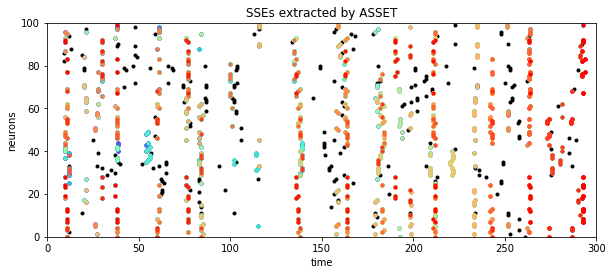

In [30]:
sse = np.load('../../ASSET_fMRI/100/sse100.npy').item()
import matplotlib
# plotting of the SSEs found in the data
inch2cm = 0.3937
fig1 = plt.figure(figsize=(25*inch2cm, 10*inch2cm))
ax1 = fig1.add_subplot(111)
number_sses = len(sse.keys())
colors = matplotlib.cm.rainbow(np.linspace(0,1,number_sses))
sts = sts[0:100]
for i, st in enumerate(sts):
    for n in st:
        ax1.set_xlim(0, 300)
        ax1.set_ylim(-0.1, 100.1)
        ax1.set_xlabel('time')
        ax1.set_ylabel('neurons')
        ax1.plot(n, i, '.', color='k')
for index_sse in range(1, number_sses):
    # number_repetitions = len(sse[index_sse])
    for key, value in sse[index_sse].items():
        for bin_item in key:
            for neuron in value:
                ax1.set_xlim(0, 300)
                ax1.set_ylim(-0.1, 100.1)
                ax1.set_xlabel('time')
                ax1.set_ylabel('neurons')
                ax1.set_title('SSEs extracted by ASSET')
                ax1.plot(bin_item, neuron, '.', color=colors[index_sse])
plt.show()

## Example of results obtained with surrogates

In [4]:
binsize = 1 * pq.s
dt = 300 * pq.s

In [5]:
# load the already computed intersection matrix
imat = np.load(path + 'imat%i.npy' % number_of_channels)
xedges = np.load(path + 'xedges%i.npy' % number_of_channels)
yedges = np.load(path + 'yedges%i.npy' % number_of_channels)

In [14]:
# calculate the probability matrix and save it
dt = 300 * pq.s
j = 5 * pq.s
pmat_montecarlo, xedges_montecarlo, yedges_montecarlo = asset.probability_matrix_montecarlo(spiketrains=sts,
                                                                                            binsize=binsize,
                                                                                            dt=dt,
                                                                                            j=j,
                                                                                            surr_method='dither_spikes')
np.save(path + 'pmat_montecarlo%i.npy' % number_of_channels, pmat)

In [16]:
# load the already computed probability matrix
pmat_montecarlo = np.load(path + 'pmat_montecarlo%i.npy' % number_of_channels)

In [17]:
filter_shape = (5,2)  # filter shape
nr_neigh = 5  # nr of largest neighbors
# calculate the joint probability matrix
jmat_montecarlo = asset.joint_probability_matrix(pmat_montecarlo, filter_shape, nr_neigh)
np.save(path + 'jmat_montecarlo%i.npy' % number_of_channels, jmat_montecarlo)

/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:1189: RuntimeWarning: divide by zero encountered in log
  dU_log = np.log(dU)


In [18]:
# load the joint probability matrix
jmat_montecarlo = np.load(path + 'jmat_montecarlo%i.npy' % number_of_channels)

In [19]:
alpha1 = 0.99
alpha2 = 0.99999
mask_montecarlo = asset.mask_matrices([pmat_montecarlo, jmat_montecarlo], [alpha1, alpha2])
np.save(path + 'mask_montecarlo%i.npy' % number_of_channels, mask_montecarlo)

In [20]:
# load the masked matrix
mask_montecarlo = np.load(path + 'mask_montecarlo%i.npy' % number_of_channels)

In [21]:
epsilon = 10
minsize = 2
stretch = 2

cmat_montecarlo = asset.cluster_matrix_entries(mask_montecarlo, epsilon, minsize, stretch)
np.save(path + 'cmat_montecarlo%i.npy' % number_of_channels, cmat_montecarlo)

/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:725: RuntimeWarning: divide by zero encountered in true_divide
  AngCoeff = dY / dX
/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:725: RuntimeWarning: invalid value encountered in true_divide
  AngCoeff = dY / dX
/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:728: RuntimeWarning: invalid value encountered in arctan
  Theta = np.arctan(AngCoeff)


In [22]:
cmat_montecarlo = np.load(path + 'cmat_montecarlo%i.npy' % number_of_channels)

In [27]:
sse_montecarlo = asset.extract_sse(sts, xedges, yedges, cmat_montecarlo)
np.save(path + 'sse_montecarlo%i.npy' % number_of_channels, sse_montecarlo)

In [28]:
sse_montecarlo = np.load(path + 'sse%i.npy' % number_of_channels).item()

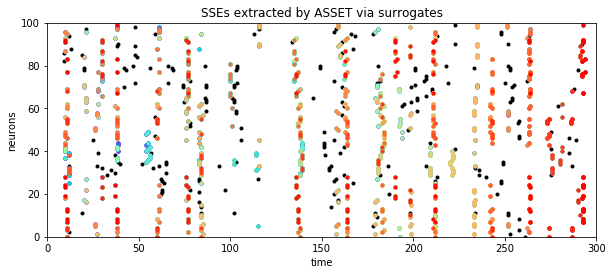

In [31]:
# plotting of the SSEs found in the data
inch2cm = 0.3937
fig1 = plt.figure(figsize=(25*inch2cm, 10*inch2cm))
ax1 = fig1.add_subplot(111)
number_sses = len(sse.keys())
colors = matplotlib.cm.rainbow(np.linspace(0,1,number_sses))
for i, st in enumerate(sts):
    for n in st:
        ax1.set_xlim(0, 300)
        ax1.set_ylim(-0.1, 100.1)
        ax1.set_xlabel('time')
        ax1.set_ylabel('neurons')
        ax1.plot(n, i, '.', color='k')
for index_sse in range(1, number_sses):
    # number_repetitions = len(sse[index_sse])
    for key, value in sse[index_sse].items():
        for bin_item in key:
            for neuron in value:
                ax1.set_xlim(0, 300)
                ax1.set_ylim(-0.1, 100.1)
                ax1.set_xlabel('time')
                ax1.set_ylabel('neurons')
                ax1.set_title('SSEs extracted by ASSET via surrogates')
                ax1.plot(bin_item, neuron, '.', color=colors[index_sse])
plt.show()
fig1.savefig(path + 'scatterplot_sse_montecarlo%i.png' % number_of_channels)

# Matrix visualization for ASSET

Figure with 5 matrices:
- Intersection matrix I
- Probability matrix P
- Joint probability matrix J
- Masked matrix M
- Cluster matrix C

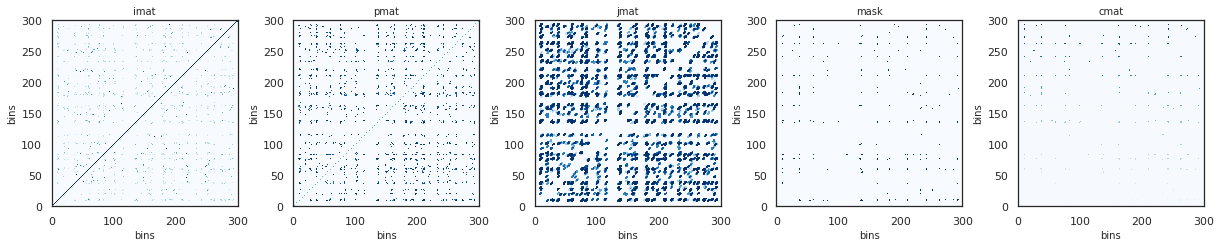

In [69]:
inch2cm = 0.3937
label_size = 10 
text_size = 8
tick_size = 5
number_of_channels = 100
path = '../../ASSET_fMRI/'
path = path + str(number_of_channels) + '/'

# fig_FPFN = plt.figure(figsize=(17*inch2cm, 25*inch2cm))
# fig_FPFN.subplots_adjust(top=.92, left=.1, right=.9, bottom=.2, hspace=0.2, wspace=00)
fig_matrices_analytical_asset = plt.figure(figsize=(20, 10))
fig_matrices_analytical_asset.subplots_adjust(top=.92, left=.1, right=.9, bottom=.2, hspace=0.2, wspace=0.3)

list_matrices = ['imat', 'pmat', 'jmat', 'mask', 'cmat']
ax = []

for index, matrix in enumerate(list_matrices):
    #load matrix
    mat = np.load(path + matrix + '%i.npy' % number_of_channels)
    ax.append(plt.subplot2grid((1,5), (0, index), rowspan=1, colspan=1, aspect=1))
    pcol = ax[index].pcolor(mat, cmap=plt.cm.Blues)
    ax[index].set_title(matrix, size=label_size)
    ax[index].set_ylabel('bins', fontsize=label_size)
    ax[index].set_xlabel('bins', fontsize=label_size)
plt.show()

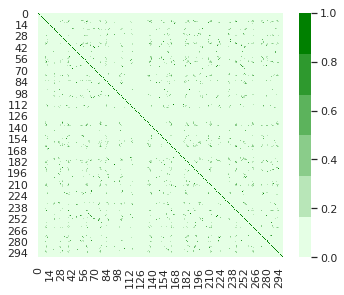

In [70]:
import seaborn as sns
sns.set(style="white")

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5.5, 4.5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = sns.light_palette("green")

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(imat, cmap=cmap)